# Preperation

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import time
import pandas as pd

C:\ProgramData\Anaconda3\lib\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.8' currently installed).
  warnings.warn(msg, UserWarning)


(668, 400, 3)
(284, 177, 3)
(923, 600, 3)
(500, 305, 3)
(1657, 1078, 3)
(1737, 1081, 3)
(280, 177, 3)
(568, 400, 3)
(1200, 767, 3)
(704, 448, 3)
(500, 278, 3)
(800, 470, 3)
(500, 332, 3)


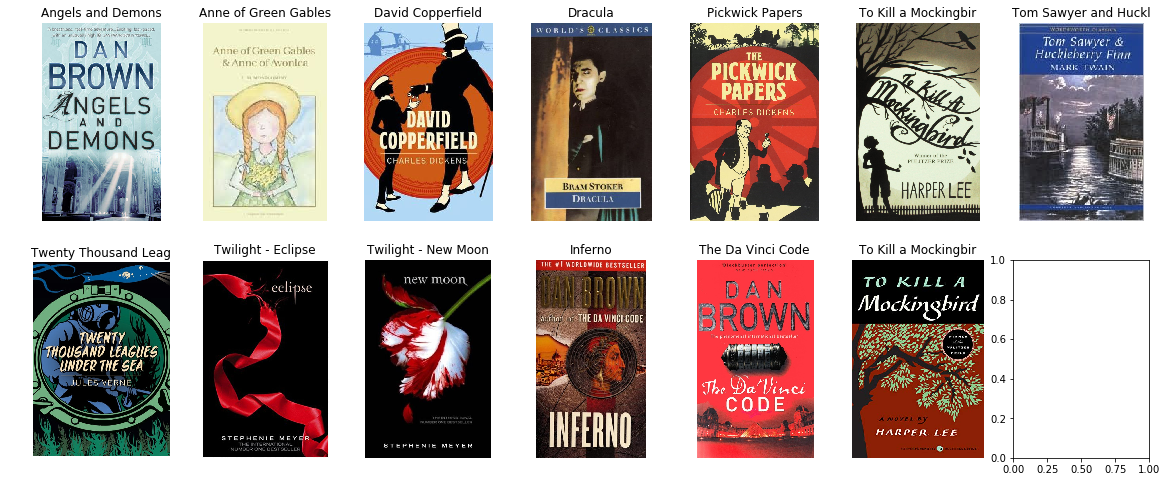

In [2]:
prefix = './data/'
postfix = '.jpg'
names = [
    'Angels and Demons',
    'Anne of Green Gables & Anne of Avonlea',
    'David Copperfield',
    'Dracula',
    'Pickwick Papers',
    'To Kill a Mockingbird',
    'Tom Sawyer and Huckleberry Finn',
    'Twenty Thousand Leagues Under the Sea',
    'Twilight - Eclipse',
    'Twilight - New Moon',
    'Inferno',
    'The Da Vinci Code',
    'To Kill a Mockingbird2'
]
imgs = {}
fig, axs = plt.subplots(2, 7, figsize=(20, 8))
for i, name in enumerate(names):
    img = cv2.imread(prefix + name + postfix)
    print(img.shape)
    imgs[name] = img
    axs[i//7, i%7].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axs[i//7, i%7].set_axis_off()
    axs[i//7, i%7].set_title(names[i][:20])
plt.show()

In [ ]:
# find min width in imgs
# min_width = min([img.shape[1] for img in imgs.values()])
min_width = 250
for name, img in imgs.items():
    img = cv2.resize(img, (min_width, int(img.shape[0]*min_width/img.shape[1])))
    imgs[name] = img

In [ ]:
trailers = {}
postfix = '.mp4'
for i, name in enumerate(names):
    cap = cv2.VideoCapture(prefix+name+postfix)
    ret, frames = cap.read()
    trailers[name] = []
    while (ret):
        trailers[name].append(frames)
        ret, frames = cap.read()
    cap.release()   

In [ ]:
test_num = 0
cap = cv2.VideoCapture(f'./test/{test_num}.mov')
ret, frame = cap.read()
frames = []
while(ret):
    frame = cv2.resize(frame, (0,0), fx=0.5, fy=0.5)
    frames.append(frame)
    # cv2.imshow('frame', frame)
    # if cv2.waitKey(1) & 0xFF == ord('q'):
    #     break
    ret, frame = cap.read()
cap.release()
cv2.destroyAllWindows()

# Feature Detection

## Keypoints and Descriptors

In [ ]:
def get_features(img, algo='sift'):
    if algo == 'sift':
        features = cv2.SIFT_create()
        keypoints, desc = features.detectAndCompute(img, None)
    if algo == 'orb':
        features = cv2.ORB_create()
        keypoints, desc = features.detectAndCompute(img, None)
    if algo == 'surf': 
        features = cv2.xfeatures2d.SURF_create(400)
        keypoints, desc = features.detectAndCompute(img, None)
    return keypoints, desc

In [ ]:
algo = 'sift'
desc = {}
keypoints = {}
fig, axs = plt.subplots(2, 7, figsize=(24, 10))
i = 0
for name, img in imgs.items():
    keypoints[name], desc[name] = get_features(img, algo)
    features_img = cv2.drawKeypoints(img, keypoints[name], None)
    axs[i//7, i%7].imshow(cv2.cvtColor(features_img, cv2.COLOR_BGR2RGB))
    axs[i//7, i%7].set_axis_off()
    axs[i//7, i%7].set_title(names[i][:20])
    i += 1
plt.show()    

## Matching

In [ ]:
def match_img(img1, img2, desc1, desc2, key1, key2, matcher='bf'):
    ''' match two images
        @param img1: image 1
        @param img2: image 2
        @param desc1: image 1's descriptors
        @param desc2: image 2's descriptors
        @param key1: image 1's keypoints
        @param key2: image 2's keypoints
        @param matcher: matching algorithm [bf (bruteforce), flann]
        @return: good matches
        @return: length of good matches
    '''
    if matcher == 'bf':
        bf = cv2.BFMatcher(normType=cv2.NORM_L2)
        matches = bf.knnMatch(desc1,desc2, k=2)

    if matcher == 'flann':
        index_params = dict(algorithm=1, trees=5)
        search_params = dict(checks=50)
        desc1 = np.float32(desc1)
        desc2 = np.float32(desc2)
        flann = cv2.FlannBasedMatcher(index_params, search_params)
        matches = flann.knnMatch(desc1,desc2, k=2)

    good = []
    for m, n in matches:
        # Lowe's ratio test
        if m.distance < 0.75*n.distance:
            good.append(m)
    # output = cv2.drawMatches(img1 = img1,
    #                                 keypoints1 = key1,
    #                                 img2 = img2,
    #                                 keypoints2 = key2,
    #                                 matches1to2 = good,
    #                                 outImg = None,
    #                                 flags = 2)
    # output = cv2.resize(output, dsize=(750, output.shape[0]*750//output.shape[1]))
    # cv2.imshow('output', output)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
    return good, len(good)

In [ ]:
def match_all(frame, imgs, desc_frame, desc, keypoints_frame, keypoints, matcher='bf'):
    ''' match a frame with covers
        @param frame: frame to be matched
        @param imgs: covers
        @param desc_frame: descriptors of frame
        @param desc: descriptors of covers
        @param keypoints_frame: keypoints of frame
        @param keypoints: keypoints of covers
        @return: matched cover
        @return: matched cover's name
    '''
    matches = {}
    goods = {}
    for name, img in imgs.items():
        goods[name], matches[name] = match_img(img, frame, desc[name], desc_frame,\
                                                 keypoints[name], keypoints_frame, matcher=matcher)
    maximum = max(matches.values())
    name = [k for k, v in matches.items() if v == maximum]
    good = [v for k, v in goods.items() if matches[k] == maximum]
    return (good[0], name[0])   

Testing a single frame:

In [ ]:
fkey, fdesc = get_features(frames[150], 'orb')
good, title = match_all(frames[150], imgs, fdesc, desc, fkey, keypoints, 'flann')
print(title)

## Exporting Video Frames

In [ ]:
def match_area(frame, keypoints, desc, imgs, algo='sift', matcher='bf'):
    ''' find matching cover and return transform matrix 
        @param frame: frame to be matched
        @param keypoints: keypoints of frame
        @param desc: descriptors of frame
        @param imgs: covers
    '''
    fkey, fdesc = get_features(frame, algo)
    good, title = match_all(frame, imgs, fdesc, desc, fkey, keypoints, matcher)
    src_points = np.float32([keypoints[title][m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
    dst_points = np.float32([fkey[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)
    # find the matched area and mark it
    M, mask = cv2.findHomography(src_points, dst_points, cv2.RANSAC, 5.0)
    if M is None:
        return None, None, None
    matches_mask = mask.ravel().tolist() 
    h,w,d = imgs[title].shape
    pts = np.float32([ [0,0], [0,h-1], [w-1,h-1], [w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts, M)
    return dst, M, title

In [3]:
# all_df = pd.DataFrame(columns=['test','feature extractor', 'matcher', 'matching time'])
# import all_df.csv to dataframe
all_df = pd.read_csv('all_df.csv')
all_df

,test,feature extractor,matcher,matching time
0,1,sift,bf,792.229039
1,1,sift,flann,664.067871
2,1,orb,bf,34.079568
3,1,orb,flann,57.356570
4,0,orb,flann,39.783368
5,0,orb,bf,31.028783
6,0,sift,flann,384.314149
7,0,sift,bf,277.731721


In [ ]:
df = pd.DataFrame(columns=['test', 'feature extractor', 'matcher', 'matching time'])

In [ ]:
algo = 'sift'
desc = {}
keypoints = {}
for name, img in imgs.items():
    keypoints[name], desc[name] = get_features(img, algo)
    features_img = cv2.drawKeypoints(img, keypoints[name], None)

In [ ]:
matched_frames = []
matching_time = 0
algo = 'sift'
matcher = 'bf'
prev_dst = None
for i, frame in enumerate(frames):
    start = time.time()
    dst, M, title = match_area(frame, keypoints, desc, imgs, algo=algo, matcher=matcher)
    matching_time += time.time() - start
    
    # if convex poly area is too small, 
    # render previous area to avoid flickering
    if dst is None or cv2.contourArea(dst) < 4500 or not cv2.isContourConvex(dst):
        if prev_dst is None:
            continue
        dst = prev_dst
        M = prev_M
        title = prev_title
    
    # mask the area
    # add the trailer frames
    for j in range(3):
        copyframe = np.zeros(frame.shape, dtype=np.uint8)
        copyframe = cv2.fillConvexPoly(copyframe, np.int32(dst), (255,255,255))
        trailer_frame = trailers[title][i*3 + j].copy()

        # crop frame to match 1.6:1 cover ratio
        h, w, _ = trailer_frame.shape
        trailer_frame = trailer_frame[:, int((w-0.625*h)//2) : int((w+0.625*h)//2), :]
        h, w, _ = trailer_frame.shape
        t_pts = np.float32([ [0,0], [0,h-1], [w-1,h-1], [w-1,0] ]).reshape(-1,1,2)
        Mt = cv2.getPerspectiveTransform(t_pts, dst)
        mask = (copyframe == (255,255,255)).all(axis=2)
        warped_trailer_frame = cv2.warpPerspective(trailer_frame, Mt, (frame.shape[1], frame.shape[0]))

        copyframe = frame.copy()
        copyframe[mask] = warped_trailer_frame[mask]
        matched_frames.append(copyframe)
    
    prev_dst = dst
    prev_M = M 
    prev_title = title

# add matching time to dataframe
df.loc[len(df)] = [test_num, algo, matcher, matching_time]
cv2.destroyAllWindows() 

In [ ]:
df

In [ ]:
# append df to all_df
all_df = all_df.append(df, ignore_index=True)
# export dataframe to csv
all_df.to_csv('all_df.csv', index=False)

In [ ]:
for f in matched_frames:
    cv2.imshow("TrailerCover", cv2.resize(f, dsize=(500, f.shape[0]*500//f.shape[1]), interpolation=cv2.INTER_AREA))
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cv2.destroyAllWindows()

In [ ]:
def export_frames(frames, path='./output/'):
    # write frames to file
    for i, f in enumerate(frames):
        cv2.imwrite(path + str(i) + '.jpg', f)

In [ ]:
def save_output(path='./output/', framerate=30, output_name='output.mp4'):
    return os.system(f"ffmpeg -r {framerate} -i {path}%d.jpg -crf 15 -b 800k -vcodec mpeg4 -y {output_name}")

In [ ]:
export_frames(matched_frames, path=f'./output/test{test_num}/')
ret = save_output(path=f'./output/test{test_num}/', framerate=30, output_name=f'output{test_num}_{algo}_{matcher}.mp4')
print(ret)

In [ ]:
import os
import glob

files = glob.glob('./output/test*/*.jpg')
for f in files:
    os.remove(f)